In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output

# Parameters for birds and the simulation
N = 200  # Number of birds
L = 500  # Size of the domain
v_max = 60  # Maximum velocity
R = 50  # Observation range
# New avoidance radi
r_free = 5  # Minimum distance to maintain for free birds
r_stuck = 3  # Minimum distance to maintain for stuck birds
lambda_c = 0.1  # Strength of the centering behavior
lambda_a = 1  # Strength of the avoiding behavior
lambda_m = 0.5  # Strength of the matching behavior
attraction_strength = 3

Nt = 500  # Number of time steps
dt = 0.25  # Time step

# Drone parameters
Nd = 1  # Number of drones
vd = 60  # Velocity of the drone
Rd = 75  # Radius of influence of the drone

# Initialize birds
def initialize_birds(N, L):
    positions = np.random.rand(N, 2) * L
    velocities = (np.random.rand(N, 2) - 0.5) * v_max
    return positions, velocities

# Initialize drones
def initialize_drones(Nd, L):
    # Initialize the drone at (250, 0) with zero velocity
    x = np.array([0] * Nd)
    y = np.array([0] * Nd)
    vx = np.array([0] * Nd)
    vy = np.array([0] * Nd)
    return x, y, vx, vy
# Initialize drone positions and velocities
drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)

# Define functions for the algorithm steps
def centre_of_mass(positions, i, R):
    neighbors = positions[np.linalg.norm(positions - positions[i], axis=1) < R]
    if len(neighbors) == 0: return np.zeros(2)
    center = np.mean(neighbors, axis=0)
    return lambda_c * (center - positions[i])

def avoid_collisions(positions, i, drone_x, drone_y, r, stuck_status, drone_avoidance_distance):
    avoid = np.zeros(2)
    # Avoid collisions with other birds
    for j, position in enumerate(positions):
        if i != j:
            distance = np.linalg.norm(position - positions[i])
            if stuck_status and distance < r_stuck:
                avoid += (positions[i] - position)
            elif not stuck_status and distance < r_free:
                avoid += (positions[i] - position)

    # Avoid collisions with the drone
    drone_distance = np.linalg.norm(np.array([drone_x[0], drone_y[0]]) - positions[i])
    if drone_distance < drone_avoidance_distance:
        avoid += (positions[i] - np.array([drone_x[0], drone_y[0]]))

    return lambda_a * avoid

def match_velocities(velocities, positions, i, R):
    neighbors = velocities[np.linalg.norm(positions - positions[i], axis=1) < R]
    if len(neighbors) == 0: return np.zeros(2)
    avg_velocity = np.mean(neighbors, axis=0)
    return lambda_m * (avg_velocity - velocities[i])

def limit_speed(velocity, v_max):
    speed = np.linalg.norm(velocity)
    if speed > v_max:
        return (velocity / speed) * v_max
    return velocity

# Your version of update_drones
def update_drones(drone_x, drone_y, drone_vx, drone_vy, x, y, L, vd, dt, stuck_birds, Rd, N, in_target_area, horizontal_movement_direction):
    Nd = len(drone_x)  # Number of drones
    target_x = 50 if horizontal_movement_direction == 1 else 450
    horizontal_end = 450  # End position for the horizontal movement
    velocity_change_factor = 0.2  # Increase smoothing factor for velocity change

    for i in range(Nd):
        if len(stuck_birds) == N:
            # Move towards the initial target position (50, 50) if not already there
            if not in_target_area or (drone_x[i], drone_y[i]) != (50, 50):
                target_y = 50
                target_dx = 50 - drone_x[i]
                target_dy = 50 - drone_y[i]
                target_distance = np.sqrt(target_dx**2 + target_dy**2)
                drone_vx[i] = vd * (target_dx / target_distance) if target_distance > 0 else 0
                drone_vy[i] = vd * (target_dy / target_distance) if target_distance > 0 else 0

                if target_distance < 10:
                    in_target_area = True
            else:
                # Horizontal movement between (50, 50) and (450, 50)
                if drone_x[i] <= 50 or drone_x[i] >= 450:
                    horizontal_movement_direction *= -1

                drone_vx[i] = horizontal_movement_direction * vd
                drone_vy[i] = 0          
        else:
            free_birds = np.array([j for j in range(N) if j not in stuck_birds])
            if len(free_birds) > 0:
                distances = np.sqrt((x[free_birds] - drone_x[i])**2 + (y[free_birds] - drone_y[i])**2)
                closest_bird = free_birds[np.argmin(distances)]
                target_dx = x[closest_bird] - drone_x[i]
                target_dy = y[closest_bird] - drone_y[i]
                target_distance = np.sqrt(target_dx**2 + target_dy**2)
                desired_vx = vd * (target_dx / target_distance) if target_distance > 0 else 0
                desired_vy = vd * (target_dy / target_distance) if target_distance > 0 else 0
                # Smoother adjustment of the drone's velocity
                drone_vx[i] = (1 - velocity_change_factor) * drone_vx[i] + velocity_change_factor * desired_vx
                drone_vy[i] = (1 - velocity_change_factor) * drone_vy[i] + velocity_change_factor * desired_vy
                if target_distance < Rd:
                    stuck_birds.add(closest_bird)
                    
        # Update drone position
        drone_x[i] += drone_vx[i] * dt
        drone_y[i] += drone_vy[i] * dt


        # Apply wall boundary conditions
        if drone_x[i] < 0 or drone_x[i] > L:
            drone_vx[i] *= -1  # Reverse x direction
            drone_x[i] = np.clip(drone_x[i], 0, L)
        if drone_y[i] < 0 or drone_y[i] > L:
            drone_vy[i] *= -1  # Reverse y direction
            drone_y[i] = np.clip(drone_y[i], 0, L)

    return drone_x, drone_y, drone_vx, drone_vy, in_target_area, horizontal_movement_direction


def update_birds(positions, velocities, R, r_free, r_stuck, v_max, drone_x, drone_y, vd, dt, Rd, stuck_birds, L, attraction_strength):
    delay_factor = 20  # Adjust for more or less delay
    drone_avoidance_distance = 2  # Minimum distance to maintain from the drone

    for i in range(N):
        is_stuck = i in stuck_birds

        if is_stuck:
            # Calculate the attraction force towards the drone
            v_c = attraction_strength * lambda_c * (np.array([drone_x[0], drone_y[0]]) - positions[i])
            v_a = avoid_collisions(positions, i, drone_x, drone_y, r_stuck, is_stuck, drone_avoidance_distance)
            v_m = match_velocities(velocities, positions, i, R)

            # Combine the flocking behavior with adjusted attraction towards the drone
            new_velocity = velocities[i] + v_c + v_a + v_m
            new_velocity = limit_speed(new_velocity, v_max)
            velocities[i] += delay_factor * (new_velocity - velocities[i])  # Apply delay
        else:
            # Normal flocking behavior for free birds
            v_c = centre_of_mass(positions, i, R)
            v_a = avoid_collisions(positions, i, drone_x, drone_y, r_free, is_stuck, drone_avoidance_distance)
            v_m = match_velocities(velocities, positions, i, R)
            velocities[i] += v_c + v_a + v_m

        # Ensure the velocity stays within max limits
        velocities[i] = limit_speed(velocities[i], v_max)

        # Update positions
        positions[i] += velocities[i] * dt

        # Implement wall boundaries
        if positions[i, 0] < 0 or positions[i, 0] > L:
            velocities[i, 0] *= -1  # Reverse direction
            positions[i, 0] = np.clip(positions[i, 0], 0, L)
        if positions[i, 1] < 0 or positions[i, 1] > L:
            velocities[i, 1] *= -1  # Reverse direction
            positions[i, 1] = np.clip(positions[i, 1], 0, L)

    return positions, velocities


def are_all_birds_stuck(stuck_birds, N):
    return len(stuck_birds) == N

def visualize(positions, velocities, drone_x, drone_y, stuck_birds):
    plt.figure(figsize=(8, 8))
    plt.xlim(0, L)
    plt.ylim(0, L)

    # Draw and label the target area as a grey square
     # Draw the target area as a grey rectangle
    plt.gca().add_patch(plt.Rectangle((0, 0), 500, 100, fill=True, color='grey', alpha=0.3, label='Target Area'))

    num_stuck_birds = len(stuck_birds)
    num_free_birds = N - num_stuck_birds

    # Plot free birds as red and stuck birds as green
    for i in range(N):
        if i in stuck_birds:
            plt.quiver(positions[i, 0], positions[i, 1], velocities[i, 0], velocities[i, 1], color='green', angles='xy', scale_units='xy', scale=25, width=0.005, headwidth=3, headlength=5)
        else:
            plt.quiver(positions[i, 0], positions[i, 1], velocities[i, 0], velocities[i, 1], color='red', angles='xy', scale_units='xy', scale=25, width=0.005, headwidth=3, headlength=5)

    plt.scatter(drone_x, drone_y, color='blue', s=100, marker='d')

    # Add text for labels and bird counts
    plt.text(550, 70, 'Attracting Drone', fontsize=12, color='blue')
    plt.text(550, 50, 'Bird Target Area', fontsize=12, color='grey')
    plt.text(550, 10, f'Stuck Birds: {num_stuck_birds}', fontsize=12, color='green')
    plt.text(550, 30, f'Free Birds: {num_free_birds}', fontsize=12, color='red')

    plt.title("Birds and Drones Interaction")
    plt.show()

horizontal_movement_direction = 1
positions, velocities = initialize_birds(N, L)
drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)
stuck_birds = set()
in_target_area = False

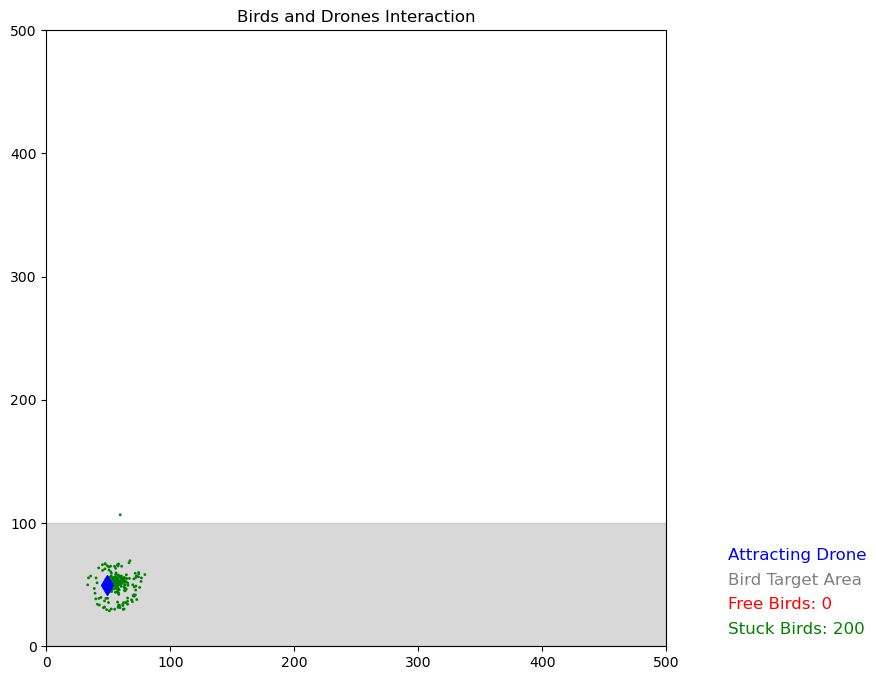

In [2]:
# Main simulation loop
for t in range(Nt):
    drone_x, drone_y, drone_vx, drone_vy, in_target_area, horizontal_movement_direction = update_drones(drone_x, drone_y, drone_vx, drone_vy, positions[:, 0], positions[:, 1], L, vd, dt, stuck_birds, Rd, N, in_target_area, horizontal_movement_direction)
    positions, velocities = update_birds(positions, velocities, R, r_free, r_stuck, v_max, drone_x, drone_y, vd, dt, Rd, stuck_birds, L, attraction_strength)  # Added attraction_strength here
    visualize(positions, velocities, drone_x, drone_y, stuck_birds)
    clear_output(wait=True)


In [26]:
Nt = 200  # Number of time steps

def is_in_target_area(position):
    # Define the target area
    target_x_min, target_x_max = 0, 500
    target_y_min, target_y_max = 0, 100
    return (position[0] >= target_x_min) & (position[0] <= target_x_max) & (position[1] >= target_y_min) & (position[1] <= target_y_max)

birds_in_target_area = []

for _ in range(Nt):
    # Update bird positions and velocities
    positions, velocities = update_birds(positions, velocities, R, r_free, r_stuck, v_max, drone_x, drone_y, vd, dt, Rd, stuck_birds, L, attraction_strength)
    drone_x, drone_y, drone_vx, drone_vy, in_target_area, horizontal_movement_direction = update_drones(drone_x, drone_y, drone_vx, drone_vy, positions[:, 0], positions[:, 1], L, vd, dt, stuck_birds, Rd, N, in_target_area, horizontal_movement_direction)

    # Get the number of birds in the target area
    birds_in_target_area.append(sum(is_in_target_area(position) for position in positions))

birds_in_target_area

[200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200

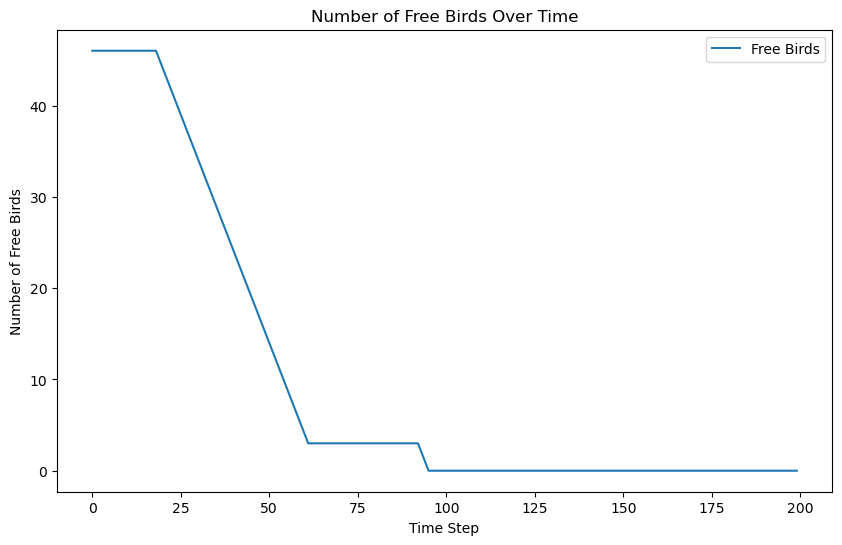

In [29]:
# Initialize the list to store the number of free birds at each time step
free_birds_over_time = []

for _ in range(Nt):
    # Update bird positions and velocities
    positions, velocities = update_birds(positions, velocities, R, r_free, r_stuck, v_max, drone_x, drone_y, vd, dt, Rd, stuck_birds, L, attraction_strength)
    drone_x, drone_y, drone_vx, drone_vy, in_target_area, horizontal_movement_direction = update_drones(drone_x, drone_y, drone_vx, drone_vy, positions[:, 0], positions[:, 1], L, vd, dt, stuck_birds, Rd, N, in_target_area, horizontal_movement_direction)

    # Calculate the number of free birds and store it
    free_birds_over_time.append(N - len(stuck_birds))

# Plot the number of free birds over time
plt.figure(figsize=(10, 6))
plt.plot(free_birds_over_time, label='Free Birds')
plt.xlabel('Time Step')
plt.ylabel('Number of Free Birds')
plt.title('Number of Free Birds Over Time')
plt.legend()
plt.show()